In [1]:
# Importar las librerías necesarias
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Cargar el archivo CSV con las etiquetas de entrenamiento
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Agregar la extensión '.tif' a los nombres de las imágenes
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
train_data, val_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])

# Verificar las dimensiones de los conjuntos
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de validación: {len(val_data)}")

Número de imágenes de entrenamiento: 176020
Número de imágenes de validación: 44005


In [3]:
# Convertir la columna 'label' a tipo string
train_data['label'] = train_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)

In [4]:
# Crear generadores de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',  # Ajusta el path al directorio con las imágenes
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',  # Ajusta el path al directorio con las imágenes
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [5]:
# Definir el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,801 (6.61 MB)

 Trainable params: 1,732,353 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 3130s 568ms/step - accuracy: 0.7941 - loss: 0.7484 - val_accuracy: 0.8322 - val_loss: 0.3740
Epoch 2/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2936s 533ms/step - accuracy: 0.8606 - loss: 0.3381 - val_accuracy: 0.7210 - val_loss: 1.0859
Epoch 3/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2504s 455ms/step - accuracy: 0.8830 - loss: 0.2955 - val_accuracy: 0.7618 - val_loss: 1.0432
Epoch 4/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2428s 441ms/step - accuracy: 0.8966 - loss: 0.2671 - val_accuracy: 0.8291 - val_loss: 0.5361
Epoch 5/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2499s 454ms/step - accuracy: 0.9004 - loss: 0.2550 - val_accuracy: 0.8182 - val_loss: 0.8777
Epoch 6/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2489s 452ms/step - accuracy: 0.9071 - loss: 0.2431 - val_accuracy: 0.7924 - val_loss: 0.5770
Epoch 7/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2665s 484ms/step - accuracy: 0.9097 - loss: 0.2375 - val_accuracy: 0.8863 - val_loss: 0.3226
Epoch 8/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2640s 479ms/step - accur

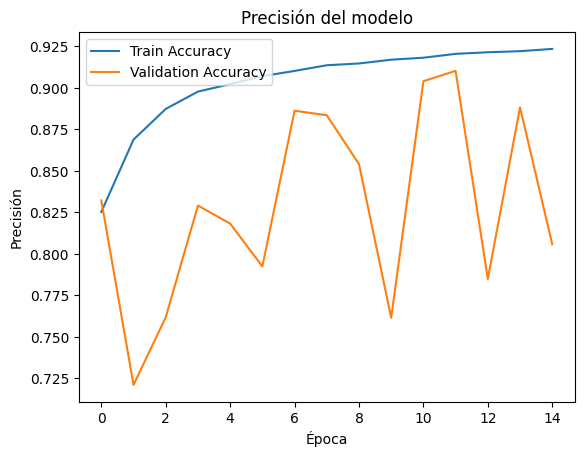

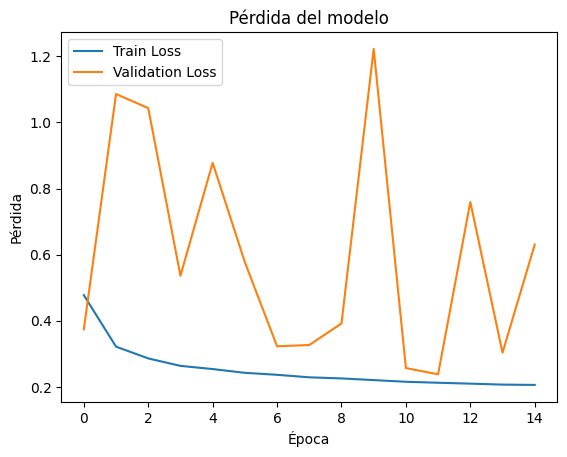

In [7]:
# Gráfico de precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.show()

# Gráfico de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.show()


In [8]:
# Obtener predicciones en el conjunto de validación
val_preds = model.predict(val_generator)
val_preds = np.round(val_preds).astype(int)

# Obtener las etiquetas verdaderas del conjunto de validación
val_labels = val_generator.classes

# Crear la matriz de confusión
cm = confusion_matrix(val_labels, val_preds)
print('Matriz de Confusión:')
print(cm)

# Mostrar el reporte de clasificación
print(classification_report(val_labels, val_preds, target_names=['Clase 0', 'Clase 1']))


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 154s 111ms/step
Matriz de Confusión:
[[20427  5755]
 [13971  3852]]
              precision    recall  f1-score   support

     Clase 0       0.59      0.78      0.67     26182
     Clase 1       0.40      0.22      0.28     17823

    accuracy                           0.55     44005
   macro avg       0.50      0.50      0.48     44005
weighted avg       0.52      0.55      0.51     44005



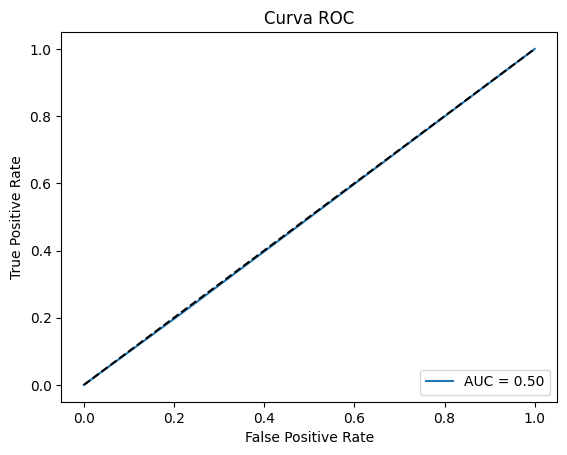

In [9]:
# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_preds)

# Visualizar la curva ROC
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
